In [ ]:
pip install tensorflow


In [ ]:
pip install gensim scikit-learn pandas numpy

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, SimpleRNN, GlobalAveragePooling1D, Flatten, Concatenate
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix,f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from tensorflow.keras import regularizers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle


# ***Predict genre based on song lyrics***

Preprocessing

In [ ]:
def preprocess(train_df, test_df):
    # Fill missing 'Lyrics' with empty strings
    train_df['Lyrics'] = train_df['Lyrics'].fillna("")
    test_df['Lyrics'] = test_df['Lyrics'].fillna("")

    # Drop rows where 'Lyrics' or 'Genre' is missing in the training set, and 'Lyrics' is missing in the test set
    train_df.dropna(subset=["Lyrics", "Genre"], inplace=True)
    test_df.dropna(subset=["Lyrics","Genre"], inplace=True)
    #train_df.dropna(subset=["Lyrics", "Genre"], axis=1)
    #test_df.dropna(subset=["Lyrics"], axis=1)
    # Convert 'Lyrics' to lowercase
    train_df['Lyrics'] = train_df['Lyrics'].astype(str).str.lower()
    test_df['Lyrics'] = test_df['Lyrics'].astype(str).str.lower()

    return train_df, test_df

In [ ]:
def vectorization(train_df,test_df):
  tfidf_vectorizer = TfidfVectorizer(max_features=5000)
  train_vec = tfidf_vectorizer.fit_transform(train_df['Lyrics'])
  test_vec = tfidf_vectorizer.transform(test_df['Lyrics'])
  return train_vec,test_vec

In [ ]:
def enc(train_df,test_df):
  label_encoder=LabelEncoder()
  train_encoded_labels=label_encoder.fit_transform(train_df["Genre"])
  test_encoded_labels=label_encoder.transform(test_df["Genre"])
  return train_encoded_labels,test_encoded_labels

In [ ]:
def encoding(train_df,test_df):
  label_encoder = LabelEncoder()
  train_encoded_labels = label_encoder.fit_transform(train_df["Genre"])
  train_labels = to_categorical(train_encoded_labels)

   #num_classes = np.max(train_labels) + 1
  test_encoded_labels=label_encoder.transform(test_df['Genre'])
  test_labels = to_categorical(test_encoded_labels)
  return train_labels,test_labels,label_encoder

In [ ]:
def tokenizing(train_df,test_df):
  # Tokenize and pad the sequences
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(train_df['Lyrics'])
  max_length = max(max(len(s.split()) for s in train_df['Lyrics']), max(len(s.split()) for s in test_df['Lyrics']))
  vocab_size = len(tokenizer.word_index) + 1

  train_sequences = tokenizer.texts_to_sequences(train_df['Lyrics'])
  train_data = pad_sequences(train_sequences, maxlen=max_length)
  test_sequences = tokenizer.texts_to_sequences(test_df['Lyrics'])
  test_data = pad_sequences(test_sequences, maxlen=max_length)
  return train_data,test_data,max_length,vocab_size

In [ ]:
def document_vector(word2vec_model, doc):
    doc = [word for word in doc.split() if word in word2vec_model.key_to_index]
    if not doc:
        return np.zeros(word2vec_model.vector_size)
    return np.mean(word2vec_model[doc], axis=0)

**SVM**

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/Part1train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/test_half.csv')

train_df,test_df=preprocess(train_df,test_df)
train_encoded_labels,test_encoded_labels=enc(train_df,test_df)
train_vec,test_vec=vectorization(train_df,test_df)

svm_classifier = LinearSVC(C=1.0, random_state=42)

#lr= LogisticRegression(max_iter=1000)
svm_classifier.fit(train_vec,train_encoded_labels)

y_pred = svm_classifier.predict(test_vec)

#find the F1 score

f1=f1_score(test_encoded_labels,y_pred,average='weighted')
print(f"F1 score:{f1}")

# Calculate Precision and Recall
precision = precision_score(test_encoded_labels,y_pred, average='weighted')
recall = recall_score(test_encoded_labels,y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')

accuracy = accuracy_score(test_encoded_labels, y_pred)
print("Accuracy ",accuracy)
# Evaluate the model
cm = confusion_matrix(test_encoded_labels, y_pred)
print("Confusion matrix",cm)
print("Validation Set Performance:")
print(classification_report(test_encoded_labels, y_pred))


#Save the model
model_file="/content/drive/MyDrive/Deep_Learning_Assignment/saved_models/svm.pkl"
with open(model_file,'wb') as f:
  pickle.dump(svm_classifier,f)

print("Model saved")

F1 score:0.14554411106135243
Precision: 0.12446985063617923
Recall: 0.20689655172413793
Accuracy  0.20689655172413793
Confusion matrix [[0 0 0 0 0]
 [0 0 6 0 2]
 [0 0 3 0 2]
 [0 0 2 0 4]
 [1 0 6 0 3]]
Validation Set Performance:
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         8
           4       0.18      0.60      0.27         5
           5       0.00      0.00      0.00         6
           6       0.27      0.30      0.29        10

    accuracy                           0.21        29
   macro avg       0.09      0.18      0.11        29
weighted avg       0.12      0.21      0.15        29



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWa

Model saved


**RNN**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 923, 50)           441450    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                7360      
                                                                 
 dense (Dense)               (None, 7)                 455       
                                                                 
Total params: 449265 (1.71 MB)
Trainable params: 449265 (1.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
22/22 [==============================] - 65s 2s/step - loss: 1.2719 - accuracy: 0.4805 - val_loss: 2.7005 - val_accuracy: 0.3161
Epoch 2/5
22/22 [==============================] - 23s 1s/step - loss: 0.8207 - accuracy: 0.5714 - val_loss: 3.3818 - val_accuracy: 0.2471
Epoch 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RNN Model saved


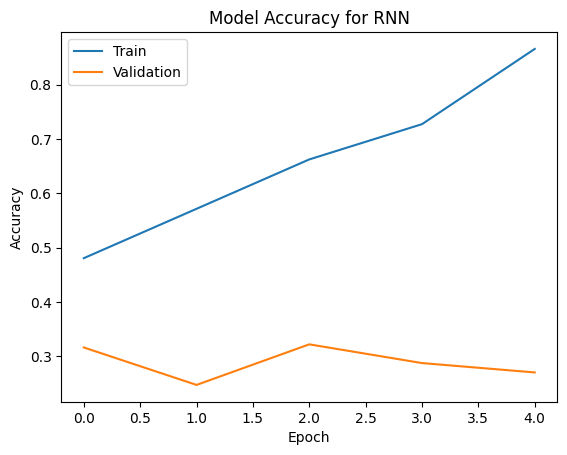

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/Part1train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/test_half.csv')

train_df,test_df=preprocess(train_df,test_df)
train_labels,test_labels,label_encoder=encoding(train_df,test_df)
train_data,test_data,max_length,vocab_size=tokenizing(train_df,test_df)

num_classes = train_labels.shape[1]
rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length),
    SimpleRNN(64, return_sequences=False),
    Dense(num_classes, activation='softmax')
])

rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model.summary()
#train the model
rnn=rnn_model.fit(train_data, train_labels, epochs=5,batch_size=32,validation_split=0.2)
#find the F1 score
y_pred_prob=rnn_model.predict(test_data)
y_pred=np.argmax(y_pred_prob,axis=1)
y_true=np.argmax(test_labels,axis=1)
f1=f1_score(y_true,y_pred,average='weighted')
print(f"F1 score:{f1}")
# Calculate Precision and Recall
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')

#check the accuracy
lo, acc = rnn_model.evaluate(test_data, test_labels)
print(f'Test accuracy: {acc}')
print(f'Loss:{lo}')

# Plot training & validation accuracy values
plt.plot(rnn.history['accuracy'])
plt.plot(rnn.history['val_accuracy'])
plt.title('Model Accuracy for RNN')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

#Save the model
rnn_model.save("/content/drive/MyDrive/Deep_Learning_Assignment/saved_models/RNN_new_model.h5")
print("RNN Model saved")

**LSTM - Single Layer**

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 923, 100)          882900    
                                                                 
 spatial_dropout1d (Spatial  (None, 923, 100)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 7)                 707       
                                                                 
Total params: 964007 (3.68 MB)
Trainable params: 964007 (3.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
22/22 - 80s - loss: 3.6782 - accuracy: 0.4502 - val_loss: 4.8836 - val_acc

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 301ms/step - loss: 2.8856 - accuracy: 0.3448
Test accuracy: 0.3448275923728943
Loss:2.8855624198913574


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


LSTM Model saved


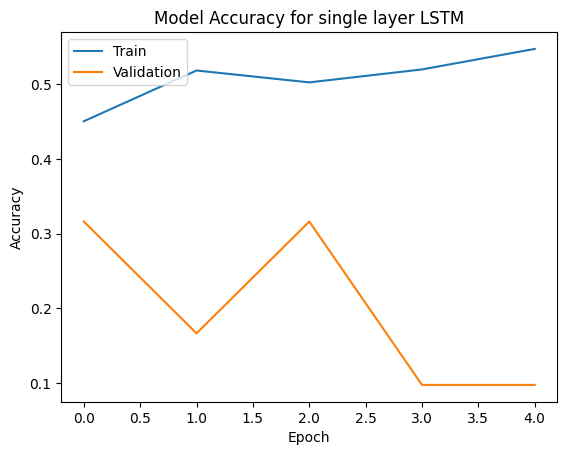

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/Part1train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/test_half.csv')

train_df,test_df=preprocess(train_df,test_df)
train_labels,test_labels,label_encoder=encoding(train_df,test_df)
train_data,test_data,max_length,vocab_size=tokenizing(train_df,test_df)

lstm_model = Sequential([
    Embedding(input_dim=vocab_size,output_dim=100, input_length=max_length),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2,recurrent_dropout=0.2, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
    Dense(len(label_encoder.classes_), activation='softmax',kernel_regularizer=l2(0.01))
])
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()
#train the model
lstm=lstm_model.fit(train_data,train_labels, epochs=5, batch_size=32, validation_split=0.2, verbose=2)
#find the F1 score
y_pred_prob=lstm_model.predict(test_data)
y_pred=np.argmax(y_pred_prob,axis=1)
y_true=np.argmax(test_labels,axis=1)
f1=f1_score(y_true,y_pred,average='weighted')
print(f"F1 score:{f1}")

# Calculate Precision and Recall
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
#check the accuracy
test_loss, test_accuracy = lstm_model.evaluate(test_data, test_labels)
print(f'Test accuracy: {test_accuracy}')
print(f'Loss:{test_loss}')

# Plot training & validation accuracy values
plt.plot(lstm.history['accuracy'])
plt.plot(lstm.history['val_accuracy'])
plt.title('Model Accuracy for single layer LSTM')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#Save the model
lstm_model.save("/content/drive/MyDrive/Deep_Learning_Assignment/saved_models/LSTM_model.h5")
print("LSTM Model saved")

**LSTM - Multi Layer**

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 923, 100)          882900    
                                                                 
 spatial_dropout1d_1 (Spati  (None, 923, 100)          0         
 alDropout1D)                                                    
                                                                 
 lstm_1 (LSTM)               (None, 923, 100)          80400     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 7)                 707       
                                                                 
Total params: 1044407 (3.98 MB)
Trainable params: 1044407 (3.98 MB)
Non-trainable params: 0 (0.00 Byte)
________________

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 739ms/step - loss: 3.1685 - accuracy: 0.1724
Test accuracy: 0.17241379618644714
Loss:3.168478488922119


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


MultiLayer LSTM Model saved


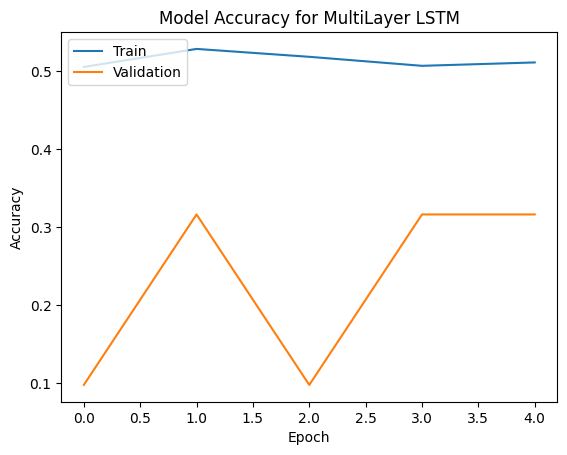

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/Part1train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/test_half.csv')

train_df,test_df=preprocess(train_df,test_df)
train_labels,test_labels,label_encoder=encoding(train_df,test_df)
train_data,test_data,max_length,vocab_size=tokenizing(train_df,test_df)

multi_lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length),
    SpatialDropout1D(0.2),
    LSTM(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2,
         kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2,  # Additional LSTM layer
         kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
    Dense(len(label_encoder.classes_), activation='softmax', kernel_regularizer=l2(0.01))
])

multi_lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
multi_lstm_model.summary()

#train the model
lstm=multi_lstm_model.fit(train_data,train_labels, epochs=5, batch_size=32, validation_split=0.2, verbose=2)
#find the F1 score
y_pred_prob=multi_lstm_model.predict(test_data)
y_pred=np.argmax(y_pred_prob,axis=1)
y_true=np.argmax(test_labels,axis=1)
f1=f1_score(y_true,y_pred,average='weighted')
print(f"F1 score:{f1}")

# Calculate Precision and Recall
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')

# Plot training & validation accuracy values
plt.plot(lstm.history['accuracy'])
plt.plot(lstm.history['val_accuracy'])
plt.title('Model Accuracy for MultiLayer LSTM')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#check the accuracy
test_loss, test_accuracy = multi_lstm_model.evaluate(test_data, test_labels)
print(f'Test accuracy: {test_accuracy}')
print(f'Loss:{test_loss}')
#Save the model
multi_lstm_model.save("/content/drive/MyDrive/Deep_Learning_Assignment/saved_models/multiLayerLSTM_model.h5")
print("MultiLayer LSTM Model saved")

**CNN**

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 923, 100)          882900    
                                                                 
 conv1d (Conv1D)             (None, 919, 128)          64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
 dense_4 (Dense)             (None, 7)                 77        
                                                                 
Total params: 948395 (3.62 MB)
Trainable params: 948395 (3.62 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


CNN Model saved


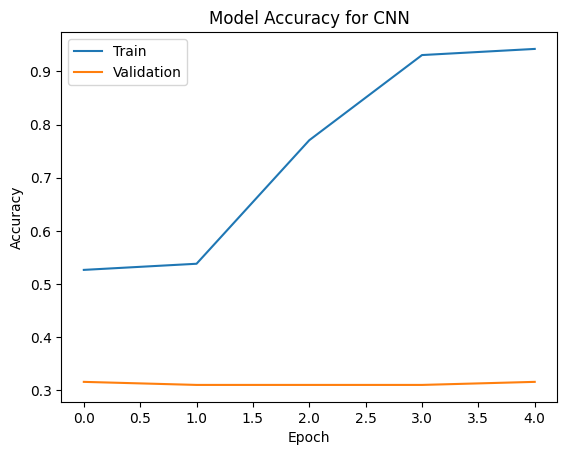

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/Part1train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/test_half.csv')


train_df,test_df=preprocess(train_df,test_df)
train_labels,test_labels,label_encoder=encoding(train_df,test_df)
train_data,test_data,max_length,vocab_size=tokenizing(train_df,test_df)

cnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=len(label_encoder.classes_), activation='softmax')
])
cnn_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
cnn_model.summary()
#train the model
cnn= cnn_model.fit(train_data,train_labels, epochs=5, batch_size=32, validation_split=0.2, verbose=2)
#find the F1 score
y_pred_prob=cnn_model.predict(test_data)
y_pred=np.argmax(y_pred_prob,axis=1)
y_true=np.argmax(test_labels,axis=1)
f1=f1_score(y_true,y_pred,average='weighted')
print(f"F1 score:{f1}")

# Calculate Precision and Recall
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')

#check the accuracy
test_loss, test_accuracy = cnn_model.evaluate(test_data, test_labels)
print(f'Test accuracy: {test_accuracy}')
print(f'Loss:{test_loss}')

# Plot training & validation accuracy values
plt.plot(cnn.history['accuracy'])
plt.plot(cnn.history['val_accuracy'])
plt.title('Model Accuracy for CNN')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#save the model
cnn_model.save("/content/drive/MyDrive/Deep_Learning_Assignment/saved_models/CNN_model.h5")
print("CNN Model saved")

**CNN with heterogenous Kernel Sizes**

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 923)]                0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 923, 100)             882900    ['input_3[0][0]']             
                                                                                                  
 conv1d_7 (Conv1D)           (None, 923, 128)             38528     ['embedding_6[0][0]']         
                                                                                                  
 conv1d_8 (Conv1D)           (None, 923, 128)             51328     ['embedding_6[0][0]']         
                                                                                            

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


CNN Model saved


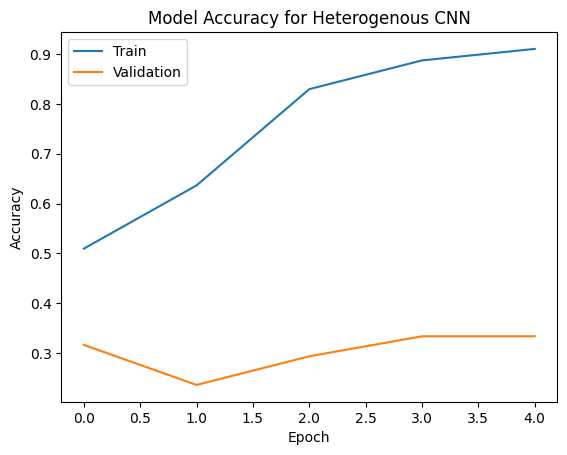

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/Part1train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/test_half.csv')

train_df,test_df=preprocess(train_df,test_df)
train_labels,test_labels,label_encoder=encoding(train_df,test_df)
train_data,test_data,max_length,vocab_size=tokenizing(train_df,test_df)


# Define the input
input_layer = Input(shape=(max_length,))

# Embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length)(input_layer)

# Convolutional paths with different kernel sizes
conv_paths = []
kernel_sizes = [3, 4, 5]
for size in kernel_sizes:
    conv_layer = Conv1D(filters=128, kernel_size=size, activation='relu', padding='same')(embedding_layer)
    pooling_layer = GlobalMaxPooling1D()(conv_layer)
    conv_paths.append(pooling_layer)

# Concatenate the features from different paths
concatenated_layer = Concatenate()(conv_paths)

# Fully connected layers
dense_layer = Dense(units=10, activation='relu', kernel_regularizer=regularizers.l2(0.01))(concatenated_layer)
output_layer = Dense(units=len(label_encoder.classes_), activation='softmax')(dense_layer)

# Build and compile the model
hetro_cnn_model = Model(inputs=input_layer, outputs=output_layer)
hetro_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
hetro_cnn_model.summary()

#train the model
cnn= hetro_cnn_model.fit(train_data,train_labels, epochs=5, batch_size=32, validation_split=0.2, verbose=2)
#find the F1 score
y_pred_prob=hetro_cnn_model.predict(test_data)
y_pred=np.argmax(y_pred_prob,axis=1)
y_true=np.argmax(test_labels,axis=1)
f1=f1_score(y_true,y_pred,average='weighted')
print(f"F1 score:{f1}")

# Calculate Precision and Recall
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')

#check the accuracy
test_loss, test_accuracy = hetro_cnn_model.evaluate(test_data, test_labels)
print(f'Test accuracy: {test_accuracy}')
print(f'Loss:{test_loss}')

plt.plot(cnn.history['accuracy'])
plt.plot(cnn.history['val_accuracy'])
plt.title('Model Accuracy for Heterogenous CNN')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

#save the model
hetro_cnn_model.save("/content/drive/MyDrive/Deep_Learning_Assignment/saved_models/hetro_CNN_model.h5")
print("CNN Model saved")

**Embedding on the fly**

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 923, 8)            40000     
                                                                 
 flatten (Flatten)           (None, 7384)              0         
                                                                 
 dense_5 (Dense)             (None, 200)               1477000   
                                                                 
 dense_6 (Dense)             (None, 7)                 1407      
                                                                 
Total params: 1518407 (5.79 MB)
Trainable params: 1518407 (5.79 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
22/22 [==============================] - 4s 163ms/step - loss: 0.9587 - accuracy: 0.5079 - val_loss: 5.0514 - val_accuracy: 0.0977
Epoch 2

1/1 [==============================] - 0s 70ms/step
F1 score:0.1434996787320625
Precision: 0.12277951933124347
Recall: 0.20689655172413793
1/1 [==============================] - 0s 36ms/step - loss: 3.4263 - accuracy: 0.2069


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Test accuracy: 0.2068965584039688
Loss:3.4262616634368896
Embedding on the fly Model saved


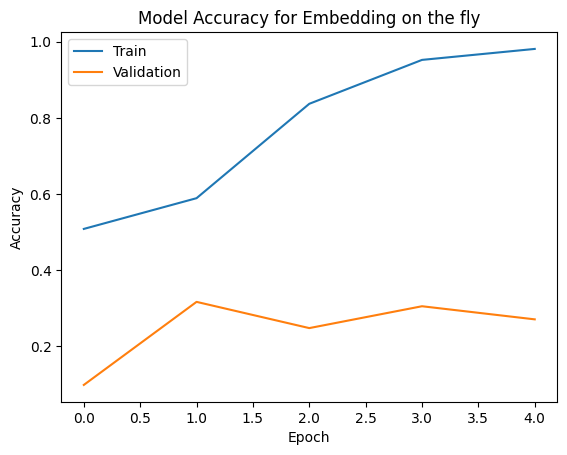

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/Part1train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/test_half.csv')

train_df,test_df=preprocess(train_df,test_df)
train_labels,test_labels,label_encoder=encoding(train_df,test_df)
train_data,test_data,max_length,vocab_size=tokenizing(train_df,test_df)

max_features = 5000
maxlen = 400
embedding_dims = 50

emb_model = Sequential()
embedding_size=8
emb_model.add(Embedding(max_features,embedding_size,input_length=max_length))
emb_model.add(Flatten())
emb_model.add(Dense(200, activation='relu'))
emb_model.add(Dense(7,activation='softmax'))

emb_model.summary()

emb_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

emb = emb_model.fit(train_data, train_labels,batch_size=32,epochs=5,validation_split=0.2)

#find the F1 score
y_pred_prob=emb_model.predict(test_data)
y_pred=np.argmax(y_pred_prob,axis=1)
y_true=np.argmax(test_labels,axis=1)
f1=f1_score(y_true,y_pred,average='weighted')
print(f"F1 score:{f1}")

# Calculate Precision and Recall
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')

#check the accuracy
test_loss, test_accuracy = emb_model.evaluate(test_data, test_labels)
print(f'Test accuracy: {test_accuracy}')
print(f'Loss:{test_loss}')

plt.plot(emb.history['accuracy'])
plt.plot(emb.history['val_accuracy'])
plt.title('Model Accuracy for Embedding on the fly')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

#Save the model
emb_model.save("/content/drive/MyDrive/Deep_Learning_Assignment/saved_models/emb_model.h5")
print("Embedding on the fly Model saved")

**Pretrained word embedding**

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 200)               60200     
                                                                 
 dense_4 (Dense)             (None, 7)                 1407      
                                                                 
Total params: 61607 (240.65 KB)
Trainable params: 61607 (240.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
22/22 [==============================] - 2s 13ms/step - loss: 1.3677 - accuracy: 0.5238 - val_loss: 2.4831 - val_accuracy: 0.3161
Epoch 2/5
22/22 [==============================] - 0s 5ms/step - loss: 0.8315 - accuracy: 0.5758 - val_loss: 3.5004 - val_accuracy: 0.3391
Epoch 3/5
22/22 [==============================] - 0s 5ms/step - loss: 0.7788 - accuracy: 0.6234 - val_loss: 3.6897 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Pretrained word Model saved


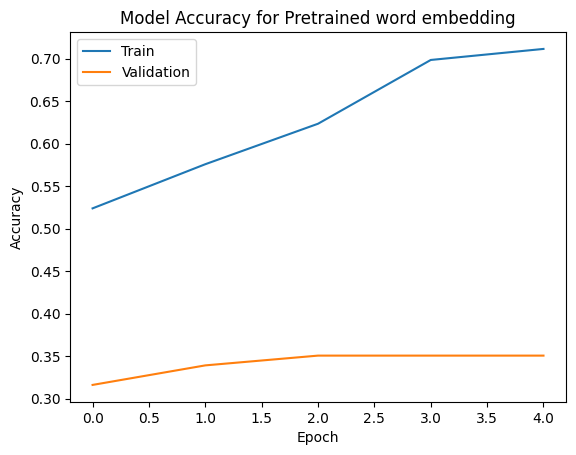

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/Part1train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/test_half.csv')

train_df,test_df=preprocess(train_df,test_df)
train_labels,test_labels,label_encoder=encoding(train_df,test_df)
train_data,test_data,max_length,vocab_size=tokenizing(train_df,test_df)

word2vec_path = '/content/drive/MyDrive/Deep_Learning_Assignment/saved_models/GoogleNews-vectors-negative300.bin'  # Example for the same directory; adjust as needed
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)


train_df['vec'] = train_df['Lyrics'].apply(lambda x: document_vector(word2vec, x))
test_df['vec']=test_df["Lyrics"].apply(lambda x: document_vector(word2vec, x))

X = np.array(train_df['vec'].tolist())
y = np.array(test_df['vec'].tolist())


pre_model = Sequential()
#No need for an embedding layer
pre_model.add(Dense(200, activation='relu',input_shape=(300,)))
pre_model.add(Dense(7,activation='softmax'))

pre_model.summary()

pre_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

pre = pre_model.fit(X, train_labels,batch_size=32,epochs=5,validation_split=0.2)

#find the F1 score
y_pred_prob=pre_model.predict(y)
y_pred=np.argmax(y_pred_prob,axis=1)
y_true=np.argmax(test_labels,axis=1)
f1=f1_score(y_true,y_pred,average='weighted')
print(f"F1 score:{f1}")

# Calculate Precision and Recall
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')

#check the accuracy
test_loss, test_accuracy = pre_model.evaluate(y, test_labels)
print(f'Test accuracy: {test_accuracy}')
print(f'Loss:{test_loss}')

plt.plot(pre.history['accuracy'])
plt.plot(pre.history['val_accuracy'])
plt.title('Model Accuracy for Pretrained word embedding')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

#Save the model
pre_model.save("/content/drive/MyDrive/Deep_Learning_Assignment/saved_models/pre_model.h5")
print("Pretrained word Model saved")

**Pretrained word embedding and logisitic regression**

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/Part1train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/test_half.csv')

train_df,test_df=preprocess(train_df,test_df)
train_labels,test_labels,label_encoder=encoding(train_df,test_df)
train_data,test_data,max_length,vocab_size=tokenizing(train_df,test_df)

#!unzip '/content/drive/MyDrive/Deep_Learning_Assignment/saved_models/GoogleNews-vectors-negative300.bin.zip' -d '/content/drive/MyDrive/Deep_Learning_Assignment/saved_models/'
word2vec_path = '/content/drive/MyDrive/Deep_Learning_Assignment/saved_models/GoogleNews-vectors-negative300.bin'  # Example for the same directory; adjust as needed
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)


train_df['vec'] = train_df['Lyrics'].apply(lambda x: document_vector(word2vec, x))
test_df['vec']=test_df["Lyrics"].apply(lambda x: document_vector(word2vec, x))

X = np.array(train_df['vec'].tolist())
y = np.array(test_df['vec'].tolist())

#lr_model = LogisticRegression(max_iter=1000)
#lr_model.fit(X,train_encoded_labels)

svm = LinearSVC(C=1.0, random_state=42)

#lr= LogisticRegression(max_iter=1000)
svm.fit(X,train_encoded_labels)
y_pred = svm.predict(y)

#find the F1 score

f1=f1_score(test_encoded_labels,y_pred,average='weighted')
print(f"F1 score:{f1}")

# Calculate Precision and Recall
precision = precision_score(test_encoded_labels,y_pred, average='weighted')
recall = recall_score(test_encoded_labels,y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')


accuracy = accuracy_score(test_encoded_labels, y_pred)
print("Accuracy ",accuracy)
# Evaluate the model
cm = confusion_matrix(test_encoded_labels, y_pred)
print("Confusion matrix",cm)
print("Validation Set Performance:")
print(classification_report(test_encoded_labels, y_pred))


#Save the model
model_file="/content/drive/MyDrive/Deep_Learning_Assignment/saved_models/l_reg.pkl"
with open(model_file,'wb') as f:
  pickle.dump(svm,f)

print("Model saved")

F1 score:0.11641615089890953
Precision: 0.11083743842364532
Recall: 0.1724137931034483
Accuracy  0.1724137931034483
Confusion matrix [[0 7 0 1]
 [0 3 0 2]
 [0 3 0 3]
 [0 8 0 2]]
Validation Set Performance:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         8
           4       0.14      0.60      0.23         5
           5       0.00      0.00      0.00         6
           6       0.25      0.20      0.22        10

    accuracy                           0.17        29
   macro avg       0.10      0.20      0.11        29
weighted avg       0.11      0.17      0.12        29



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

Model saved


# ***Predict genre based on song lyrics and artist***

In [ ]:
def preprocess_2(train_df, test_df):
    # Fill missing 'Lyrics' with empty strings
    train_df['Lyrics'] = train_df['Lyrics'].fillna("")
    test_df['Lyrics'] = test_df['Lyrics'].fillna("")
    train_df["Artist"]=train_df["Artist"].fillna("")
    test_df["Artist"]=test_df["Artist"].fillna("")

    # Drop rows where 'Lyrics' or 'Genre' is missing in the training set, and 'Lyrics' is missing in the test set
    train_df.dropna(subset=["Lyrics", "Genre"], inplace=True)
    test_df.dropna(subset=["Lyrics","Genre"], inplace=True)


    # Convert 'Lyrics' to lowercase
    train_df['Lyrics'] = train_df['Lyrics'].astype(str).str.lower()
    test_df['Lyrics'] = test_df['Lyrics'].astype(str).str.lower()
    train_df['Artist'] = train_df['Artist'].astype(str).str.lower()
    test_df['Artist'] = test_df['Artist'].astype(str).str.lower()
    return train_df, test_df

In [ ]:
def vectorization_2(train_df,test_df):
  # Combine 'Lyrics' and 'Artist' into a single string per row for both train and test DataFrames
  train_combined = train_df['Lyrics'] + " " + train_df['Artist']
  test_combined = test_df['Lyrics'] + " " + test_df['Artist']
  tfidf_vectorizer = TfidfVectorizer(max_features=5000)
  train_vec = tfidf_vectorizer.fit_transform(train_combined)
  test_vec = tfidf_vectorizer.transform(test_combined)
  return train_vec,test_vec

In [ ]:
def enc_2(train_df,test_df):
  label_encoder=LabelEncoder()
  train_encoded_labels=label_encoder.fit_transform(train_df["Genre"])
  test_encoded_labels=label_encoder.transform(test_df["Genre"])
  return train_encoded_labels,test_encoded_labels

In [ ]:
def encoding_2(train_df,test_df):
  label_encoder = LabelEncoder()
  train_encoded_labels = label_encoder.fit_transform(train_df["Genre"])
  train_labels = to_categorical(train_encoded_labels)

   #num_classes = np.max(train_labels) + 1
  test_encoded_labels=label_encoder.transform(test_df['Genre'])
  test_labels = to_categorical(test_encoded_labels)
  return train_labels,test_labels,label_encoder

In [ ]:
def tokenizing_2(train_df, test_df):
    # Initialize tokenizers
    lyrics_tokenizer = Tokenizer()
    artist_tokenizer = Tokenizer()

    # Fit the tokenizers
    lyrics_tokenizer.fit_on_texts(train_df['Lyrics'])
    artist_tokenizer.fit_on_texts(train_df['Artist'])

    # Find the maximum length for padding
    lyrics_max_length = max(max(len(s.split()) for s in train_df['Lyrics']),
                            max(len(s.split()) for s in test_df['Lyrics']))
    artist_max_length = max(max(len(s.split()) for s in train_df['Artist']),
                            max(len(s.split()) for s in test_df['Artist']))

    # Vocabulary sizes
    lyrics_vocab_size = len(lyrics_tokenizer.word_index) + 1
    artist_vocab_size = len(artist_tokenizer.word_index) + 1

    # Tokenize and pad the sequences
    # Lyrics
    train_lyrics_sequences = lyrics_tokenizer.texts_to_sequences(train_df['Lyrics'])
    train_lyrics_data = pad_sequences(train_lyrics_sequences, maxlen=lyrics_max_length)
    test_lyrics_sequences = lyrics_tokenizer.texts_to_sequences(test_df['Lyrics'])
    test_lyrics_data = pad_sequences(test_lyrics_sequences, maxlen=lyrics_max_length)

    # Artist
    train_artist_sequences = artist_tokenizer.texts_to_sequences(train_df['Artist'])
    train_artist_data = pad_sequences(train_artist_sequences, maxlen=artist_max_length)
    test_artist_sequences = artist_tokenizer.texts_to_sequences(test_df['Artist'])
    test_artist_data = pad_sequences(test_artist_sequences, maxlen=artist_max_length)

    return (train_lyrics_data, train_artist_data, test_lyrics_data, test_artist_data,
            lyrics_max_length, artist_max_length, lyrics_vocab_size, artist_vocab_size)

***SVM***

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/Part1train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/test_half.csv')

train_df,test_df=preprocess_2(train_df,test_df)
train_encoded_labels,test_encoded_labels=enc_2(train_df,test_df)
train_vec,test_vec=vectorization_2(train_df,test_df)

svm_classifier = LinearSVC(C=1.0, random_state=42)

#lr= LogisticRegression(max_iter=1000)
svm_classifier.fit(train_vec,train_encoded_labels)

y_pred = svm_classifier.predict(test_vec)
#find the F1 score

f1=f1_score(test_encoded_labels,y_pred,average='weighted')
print(f"F1 score:{f1}")

# Calculate Precision and Recall
precision = precision_score(test_encoded_labels,y_pred, average='weighted')
recall = recall_score(test_encoded_labels,y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')


accuracy = accuracy_score(test_encoded_labels, y_pred)
print("Accuracy ",accuracy)
# Evaluate the model
cm = confusion_matrix(test_encoded_labels, y_pred)
print("Confusion matrix",cm)
print("Validation Set Performance:")
print(classification_report(test_encoded_labels, y_pred))


#Save the model
model_file="/content/drive/MyDrive/Deep_Learning_Assignment/saved_models/svm_lyrics_artist.pkl"
with open(model_file,'wb') as f:
  pickle.dump(svm_classifier,f)

print("Model saved")

F1 score:0.17465293327362288
Precision: 0.14727011494252873
Recall: 0.2413793103448276
Accuracy  0.2413793103448276
Confusion matrix [[0 0 0 0 0]
 [0 0 6 0 2]
 [0 0 3 0 2]
 [0 0 2 0 4]
 [1 0 5 0 4]]
Validation Set Performance:
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         8
           4       0.19      0.60      0.29         5
           5       0.00      0.00      0.00         6
           6       0.33      0.40      0.36        10

    accuracy                           0.24        29
   macro avg       0.10      0.20      0.13        29
weighted avg       0.15      0.24      0.17        29



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWa

Model saved


***RNN***

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/Part1train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/test_half.csv')

train_df,test_df=preprocess_2(train_df,test_df)
train_labels,test_labels,label_encoder=encoding_2(train_df,test_df)
train_lyrics_data, train_artist_data, test_lyrics_data, test_artist_data, lyrics_max_length, artist_max_length, lyrics_vocab_size, artist_vocab_size=tokenizing_2(train_df, test_df)

num_classes = train_labels.shape[1]
# Define inputs
lyrics_input = Input(shape=(lyrics_max_length,), dtype='int32', name='lyrics_input')
artist_input = Input(shape=(artist_max_length,), dtype='int32', name='artist_input')

# Embeddings
lyrics_embedding = Embedding(input_dim=lyrics_vocab_size, output_dim=50, input_length=lyrics_max_length)(lyrics_input)
artist_embedding = Embedding(input_dim=artist_vocab_size, output_dim=50, input_length=artist_max_length)(artist_input)

# Process Lyrics Embedding
lyrics_rnn = SimpleRNN(64)(lyrics_embedding)  # Consider using LSTM or GRU for better performance

# Process Artist Embedding
artist_rnn = SimpleRNN(64)(artist_embedding)  # Same here, LSTM or GRU could be more appropriate

# Merge the outputs from both RNNs
merged = Concatenate(axis=-1)([lyrics_rnn, artist_rnn])

# Output layer
output = Dense(num_classes, activation='softmax')(merged)

# Build and compile the model as before
rnn_model = Model(inputs=[lyrics_input, artist_input], outputs=output)
rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Now, train the model. Make sure to pass the inputs as a list in the same order as defined.
rnn_model.fit([train_lyrics_data, train_artist_data], train_labels, epochs=5, batch_size=32, validation_split=0.2)
#find the F1 score
y_pred_prob=rnn_model.predict([test_lyrics_data, test_artist_data])
y_pred=np.argmax(y_pred_prob,axis=1)
y_true=np.argmax(test_labels,axis=1)
f1=f1_score(y_true,y_pred,average='weighted')
print(f"F1 score:{f1}")

# Calculate Precision and Recall
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')

#check the accuracy
lo, acc = rnn_model.evaluate([test_lyrics_data, test_artist_data], test_labels)
print(f'Test accuracy: {acc}')
print(f'Loss:{lo}')
#Save the model
rnn_model.save("/content/drive/MyDrive/Deep_Learning_Assignment/saved_models/RNN_new_model_lyrics_artist.h5")
print("RNN Model saved")

Epoch 1/5
22/22 [==============================] - 25s 1s/step - loss: 1.0903 - accuracy: 0.5873 - val_loss: 2.9168 - val_accuracy: 0.3506
Epoch 2/5
22/22 [==============================] - 23s 1s/step - loss: 0.4923 - accuracy: 0.9293 - val_loss: 3.6906 - val_accuracy: 0.3161
Epoch 3/5
22/22 [==============================] - 20s 933ms/step - loss: 0.1898 - accuracy: 0.9913 - val_loss: 3.6905 - val_accuracy: 0.3161
Epoch 4/5
22/22 [==============================] - 22s 947ms/step - loss: 0.0516 - accuracy: 1.0000 - val_loss: 3.8384 - val_accuracy: 0.3161
Epoch 5/5
1/1 [==============================] - 0s 385ms/step
F1 score:0.1768346595932803
Precision: 0.11890606420927469
Recall: 0.3448275862068966
1/1 [==============================] - 0s 128ms/step - loss: 3.1833 - accuracy: 0.3448


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test accuracy: 0.3448275923728943
Loss:3.1833224296569824


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RNN Model saved


***LSTM***

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/Part1train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/test_half.csv')

train_df,test_df=preprocess_2(train_df,test_df)
train_labels,test_labels,label_encoder=encoding_2(train_df,test_df)
train_lyrics_data, train_artist_data, test_lyrics_data, test_artist_data, lyrics_max_length, artist_max_length, lyrics_vocab_size, artist_vocab_size=tokenizing_2(train_df, test_df)


# Define two inputs
lyrics_input = Input(shape=(lyrics_max_length,), dtype='int32', name='lyrics_input')
artist_input = Input(shape=(artist_max_length,), dtype='int32', name='artist_input')

# Embeddings
lyrics_embedding = Embedding(input_dim=lyrics_vocab_size, output_dim=100, input_length=lyrics_max_length)(lyrics_input)
artist_embedding = Embedding(input_dim=artist_vocab_size, output_dim=100, input_length=artist_max_length)(artist_input)

# LSTM layers
lyrics_lstm = LSTM(100, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))(lyrics_embedding)
artist_lstm = LSTM(100, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))(artist_embedding)

# Concatenate the outputs of the two LSTMs
concatenated = Concatenate()([lyrics_lstm, artist_lstm])

# Add one or more dense layers
dense_layer = Dense(100, activation='relu', kernel_regularizer=l2(0.01))(concatenated)

# Output layer
output = Dense(len(label_encoder.classes_), activation='softmax')(dense_layer)

# Create the model
lstm_model = Model(inputs=[lyrics_input, artist_input], outputs=output)

# Compile the model
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
lstm_model.summary()

# Train the model
# Note: You need to pass a list of numpy arrays as training data: one for lyrics and one for artists
lstm_model.fit([train_lyrics_data, train_artist_data], train_labels, epochs=5, batch_size=32, validation_split=0.2, verbose=2)

#find the F1 score
y_pred_prob=lstm_model.predict([test_lyrics_data, test_artist_data])
y_true=np.argmax(test_labels,axis=1)
y_pred=np.argmax(y_pred_prob,axis=1)
f1=f1_score(y_true,y_pred,average='weighted')
print(f"F1 score:{f1}")

# Calculate Precision and Recall
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')

#check the accuracy
test_loss, test_accuracy = lstm_model.evaluate([test_lyrics_data, test_artist_data], test_labels)
print(f'Loss:{test_loss}')
print(f'Test accuracy: {test_accuracy}')
#Save the model
lstm_model.save("/content/drive/MyDrive/Deep_Learning_Assignment/saved_models/LSTM_model_lyrics_artist.h5")
print("LSTM Model saved")

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lyrics_input (InputLayer)   [(None, 923)]                0         []                            
                                                                                                  
 artist_input (InputLayer)   [(None, 3)]                  0         []                            
                                                                                                  
 embedding_9 (Embedding)     (None, 923, 100)             882900    ['lyrics_input[0][0]']        
                                                                                                  
 embedding_10 (Embedding)    (None, 3, 100)               2700      ['artist_input[0][0]']        
                                                                                            

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 274ms/step - loss: 2.9955 - accuracy: 0.3448
Loss:2.9954590797424316
Test accuracy: 0.3448275923728943


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


LSTM Model saved


***CNN***

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/Part1train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/test_half.csv')

train_df,test_df=preprocess_2(train_df,test_df)
train_labels,test_labels,label_encoder=encoding_2(train_df,test_df)
train_lyrics_data, train_artist_data, test_lyrics_data, test_artist_data, lyrics_max_length, artist_max_length, lyrics_vocab_size, artist_vocab_size=tokenizing_2(train_df, test_df)

# Inputs
lyrics_input = Input(shape=(lyrics_max_length,), dtype='int32', name='lyrics_input')
artist_input = Input(shape=(artist_max_length,), dtype='int32', name='artist_input')

# Embeddings
lyrics_embedding = Embedding(input_dim=lyrics_vocab_size, output_dim=100, input_length=lyrics_max_length)(lyrics_input)
artist_embedding = Embedding(input_dim=artist_vocab_size, output_dim=100, input_length=artist_max_length)(artist_input)


# CNN layers for each input
lyrics_cnn = Conv1D(filters=128, kernel_size=5, activation='relu')(lyrics_embedding)
lyrics_pooling = GlobalMaxPooling1D()(lyrics_cnn)
artist_cnn = Conv1D(filters=128, kernel_size=3, activation='relu')(artist_embedding)
artist_pooling = GlobalMaxPooling1D()(artist_cnn)

# Concatenate the outputs of the two CNN paths
concatenated = Concatenate()([lyrics_pooling, artist_pooling])

# Dense layers
dense_layer = Dense(units=10, activation='relu')(concatenated)

# Output layer
output = Dense(units=len(label_encoder.classes_), activation='softmax')(dense_layer)

# Create the model
cnn_model = Model(inputs=[lyrics_input, artist_input], outputs=output)

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
cnn_model.summary()

# Train the model
cnn_model.fit([train_lyrics_data, train_artist_data], train_labels, epochs=5, batch_size=32, validation_split=0.2, verbose=2)
#find the F1 score
y_pred_prob=cnn_model.predict([test_lyrics_data, test_artist_data])
y_pred=np.argmax(y_pred_prob,axis=1)
y_true=np.argmax(test_labels,axis=1)
f1=f1_score(y_true,y_pred,average='weighted')
print(f"F1 score:{f1}")

# Calculate Precision and Recall
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')

#check the accuracy
test_loss, test_accuracy = cnn_model.evaluate([test_lyrics_data, test_artist_data], test_labels)
print(f'Test accuracy: {test_accuracy}')
print(f'Loss:{test_loss}')
#save the model
cnn_model.save("/content/drive/MyDrive/Deep_Learning_Assignment/saved_models/CNN_model_lyrics_artist.h5")
print("CNN Model saved")

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lyrics_input (InputLayer)   [(None, 923)]                0         []                            
                                                                                                  
 artist_input (InputLayer)   [(None, 3)]                  0         []                            
                                                                                                  
 embedding_11 (Embedding)    (None, 923, 100)             882900    ['lyrics_input[0][0]']        
                                                                                                  
 embedding_12 (Embedding)    (None, 3, 100)               2700      ['artist_input[0][0]']        
                                                                                            

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


CNN Model saved


***Embedding on the fly***

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/Part1train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/test_half.csv')

train_df,test_df=preprocess_2(train_df,test_df)
train_labels,test_labels,label_encoder=encoding_2(train_df,test_df)
train_lyrics_data, train_artist_data, test_lyrics_data, test_artist_data, lyrics_max_length, artist_max_length, lyrics_vocab_size, artist_vocab_size=tokenizing_2(train_df, test_df)

embedding_dims=50
# Define model parameters
lyrics_input = Input(shape=(lyrics_max_length,), dtype='int32', name='lyrics_input')
artist_input = Input(shape=(artist_max_length,), dtype='int32', name='artist_input')

# Embedding layers
lyrics_embedding = Embedding(input_dim=lyrics_vocab_size, output_dim=embedding_dims, input_length=lyrics_max_length)(lyrics_input)
artist_embedding = Embedding(input_dim=artist_vocab_size, output_dim=embedding_dims, input_length=artist_max_length)(artist_input)

# Flatten the embeddings
lyrics_flatten = Flatten()(lyrics_embedding)
artist_flatten = Flatten()(artist_embedding)

# Concatenate the flattened outputs
concatenated = Concatenate()([lyrics_flatten, artist_flatten])

# Dense layers
dense_layer = Dense(200, activation='relu')(concatenated)
output = Dense(len(label_encoder.classes_), activation='softmax')(dense_layer)

# Create the model
emb_model = Model(inputs=[lyrics_input, artist_input], outputs=output)

# Compile the model
emb_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
emb_model.summary()

# Train the model
emb_model.fit([train_lyrics_data, train_artist_data], train_labels, batch_size=32, epochs=4, validation_split=0.2)


#find the F1 score
y_pred_prob=emb_model.predict([test_lyrics_data, test_artist_data])
y_pred=np.argmax(y_pred_prob,axis=1)
y_true=np.argmax(test_labels,axis=1)
f1=f1_score(y_true,y_pred,average='weighted')
print(f"F1 score:{f1}")

# Calculate Precision and Recall
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')

#check the accuracy
test_loss, test_accuracy = emb_model.evaluate([test_lyrics_data, test_artist_data], test_labels)
print(f'Test accuracy: {test_accuracy}')
print(f'Loss:{test_loss}')

#Save the model
emb_model.save("/content/drive/MyDrive/Deep_Learning_Assignment/saved_models/emb_model_lyrics_artist.h5")
print("Embedding on the fly Model saved")

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lyrics_input (InputLayer)   [(None, 923)]                0         []                            
                                                                                                  
 artist_input (InputLayer)   [(None, 3)]                  0         []                            
                                                                                                  
 embedding_13 (Embedding)    (None, 923, 50)              441450    ['lyrics_input[0][0]']        
                                                                                                  
 embedding_14 (Embedding)    (None, 3, 50)                1350      ['artist_input[0][0]']        
                                                                                            

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Embedding on the fly Model saved


***Pretrained word embedding***

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/Part1train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/dataset/Multilingual/test_half.csv')

train_df,test_df=preprocess_2(train_df,test_df)
train_labels,test_labels,label_encoder=encoding_2(train_df,test_df)
train_lyrics_data, train_artist_data, test_lyrics_data, test_artist_data, lyrics_max_length, artist_max_length, lyrics_vocab_size, artist_vocab_size=tokenizing_2(train_df, test_df)


word2vec_path = '/content/drive/MyDrive/Deep_Learning_Assignment/saved_models/GoogleNews-vectors-negative300.bin'  # Example for the same directory; adjust as needed
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)


train_df['vec'] = train_df['Lyrics'].apply(lambda x: document_vector(word2vec, x))
test_df['vec']=test_df["Lyrics"].apply(lambda x: document_vector(word2vec, x))

from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False,handle_unknown="ignore")  # Ensure output is a dense matrix

# Fit and transform the artist names

artist_train_encoded = encoder.fit_transform(train_df[['Artist']].values.reshape(-1, 1))
artist_test_encoded = encoder.transform(test_df[['Artist']].values.reshape(-1, 1))

X = np.array(train_df['vec'].tolist())
y = np.array(test_df['vec'].tolist())

X_combined=np.concatenate([X, artist_train_encoded], axis=1)
y_combined=np.concatenate([y, artist_test_encoded], axis=1)
input_shape = X_combined.shape[1]


pre_model = Sequential()
#No need for an embedding layer
pre_model.add(Dense(200, activation='relu',input_shape=(input_shape,)))
pre_model.add(Dense(7,activation='softmax'))

pre_model.summary()

pre_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

pre = pre_model.fit(X_combined, train_labels,batch_size=32,epochs=4,validation_split=0.2)

#find the F1 score
y_pred_prob=pre_model.predict(y_combined)
y_pred=np.argmax(y_pred_prob,axis=1)
y_true=np.argmax(test_labels,axis=1)
f1=f1_score(y_true,y_pred,average='weighted')
print(f"F1 score:{f1}")

# Calculate Precision and Recall
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')

#check the accuracy
test_loss, test_accuracy = pre_model.evaluate(y_combined, test_labels)
print(f'Test accuracy: {test_accuracy}')
print(f'Loss:{test_loss}')

#Save the model
pre_model.save("/content/drive/MyDrive/Deep_Learning_Assignment/saved_models/pre_model_Lyrics_Artist.h5")
print("Pretrained word Model saved")

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 200)               63000     
                                                                 
 dense_25 (Dense)            (None, 7)                 1407      
                                                                 
Total params: 64407 (251.59 KB)
Trainable params: 64407 (251.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/4
22/22 [==============================] - 1s 12ms/step - loss: 1.2111 - accuracy: 0.8831 - val_loss: 2.3200 - val_accuracy: 0.3103
Epoch 2/4
22/22 [==============================] - 0s 5ms/step - loss: 0.5059 - accuracy: 0.9524 - val_loss: 3.1788 - val_accuracy: 0.3333
Epoch 3/4
22/22 [==============================] - 0s 5ms/step - loss: 0.3203 - accuracy: 0.9711 - val_loss: 3.3198 - val_accuracy: 0.3276
Epoch 4/4
1/1 [==============================] - 0s 45ms/step
F1 score:0.04449388209121246
Precision: 0.026525198938992044
Recall: 0.13793103448275862
1/1 [==============================] - 0s 26ms/step - loss: 2.4169 - accuracy: 0.1379
Test accuracy: 0.13793103396892548
Loss:2.4169020652770996


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Pretrained word Model saved
